In [1]:
# Useful packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sage
import seaborn as sns
from collections import Counter, defaultdict
import itertools
import math

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from sklearn.metrics import brier_score_loss
from sklearn.dummy import DummyClassifier


# Generating the dataset
We take the led dataset and add noise to it to introduce randomness and compare between train and test sets.

In [2]:
def make_noised_led_sample(
    n_samples=200, irrelevant=0, flip_proba=0.1, random_state=None
):
    random_state = check_random_state(random_state)

    data = np.array(
        [
            [0, 0, 1, 0, 0, 1, 0, 1],
            [1, 0, 1, 1, 1, 0, 1, 2],
            [1, 0, 1, 1, 0, 1, 1, 3],
            [0, 1, 1, 1, 0, 1, 0, 4],
            [1, 1, 0, 1, 0, 1, 1, 5],
            [1, 1, 0, 1, 1, 1, 1, 6],
            [1, 0, 1, 0, 0, 1, 0, 7],
            [1, 1, 1, 1, 1, 1, 1, 8],
            [1, 1, 1, 1, 0, 1, 1, 9],
            [1, 1, 1, 0, 1, 1, 1, 0],
        ]
    )

    data = data[random_state.randint(0, 10, n_samples)]
    X, y = np.array(data[:, :7], dtype=np.intp), data[:, 7]
    X_noised = np.zeros_like(X)
    for sample in range(n_samples):
        X_noised[sample, :] = np.abs(
            random_state.binomial(n=1, p=flip_proba, size=7) - X[sample, :]
        )
    if irrelevant > 0:
        X_noised = np.hstack((X_noised, random_state.rand(n_samples, irrelevant) > 0.5))
    return X_noised, y


# Compare asymptotics of MDI and UMDI

In [3]:
n_rep = 5
flip_proba = 0.2
max_n_sample = 1e4
n_estimators = 100
train_sizes_large = np.logspace(start=2, stop=np.log10(max_n_sample), base=10, num=10, dtype=np.intp)


In [4]:
feature_names = ["x1", "x2", "x3", "x4", "x5", "x6", "x7"]
mdi_all = np.zeros((len(feature_names), len(train_sizes_large), n_rep))
umdi_all = np.zeros((len(feature_names), len(train_sizes_large), n_rep))
oob_scores= []
for t_idx, n_samples in enumerate(train_sizes_large):
    oob_scores_fold = []
    for rep in range(n_rep):
        X_train, y_train = make_noised_led_sample(
            n_samples=n_samples, flip_proba=flip_proba, random_state=rep
        )
        X_train = X_train.astype(np.float32)
        rf = ExtraTreesClassifier(
            n_estimators=n_estimators,
            max_features=1,
            max_depth=None,
            oob_score=True,
            bootstrap=True,
            n_jobs=-1,
            random_state=rep,
        )
        rf.fit(X_train, y_train)     
        mdi_all[:, t_idx, rep] = rf._unnormalized_feature_importances
        umdi_all[:, t_idx, rep] = rf.unbiased_feature_importances_
        oob_scores_fold.append(rf.oob_score_)
    oob_scores.append(np.mean(oob_scores_fold))

In [5]:
# Compute shapley values
sage_values = []
n_samples_train_sage = int(1e5)
n_samples_test_sage = int(1e5)
for rep in range(n_rep):
    X_train, y_train = make_noised_led_sample(
        n_samples=n_samples_train_sage, flip_proba=flip_proba, random_state=rep
    )

    rf = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_features=1,
        max_depth=None,
        oob_score=True,
        bootstrap=True,
        n_jobs=-1,
        random_state=rep,
    )
    rf.fit(X_train, y_train)
    
    X_test, y_test = make_noised_led_sample(
        n_samples=n_samples_test_sage, flip_proba=flip_proba, random_state=rep + 100
    )
    y_test_one_hot = np.eye(10)[y_test]
    imputer = sage.MarginalImputer(rf, X_test[:500])
    estimator = sage.PermutationEstimator(
        imputer, "mse", random_state=rep
    )
    sage_value = estimator(X_test, y_test_one_hot, thresh=0.05).values
    sage_values.append(sage_value)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

# Compute FI as a decomposition of mutual information

In [6]:
def conditional_mutual_information(X, y, m, S):
    n_samples = X.shape[0]
    counter = Counter()

    # Build joint frequency tables
    for i in range(n_samples):
        x_m = X[i, m]
        s_vals = tuple(X[i, S]) if len(S) > 0 else ()
        y_val = y[i]
        counter[('xmys', x_m, y_val, s_vals)] += 1
        counter[('xms', x_m, s_vals)] += 1
        counter[('ys', y_val, s_vals)] += 1
        counter[('s', s_vals)] += 1

    cmi = 0.0
    for key_tuple, p_joint_count in counter.items():
        key = key_tuple[0]
        if key != 'xmys':
            continue
        _, x_m, y_val, s_vals = key_tuple
        p_xyz = p_joint_count / n_samples
        p_xz = counter[('xms', x_m, s_vals)] / n_samples
        p_yz = counter[('ys', y_val, s_vals)] / n_samples
        p_z = counter[('s', s_vals)] / n_samples


        # Avoid division by zero
        if p_xyz > 0 and p_xz > 0 and p_yz > 0 and p_z > 0:
            cmi += p_xyz * np.log(p_xyz * p_z / (p_xz * p_yz))

    return cmi

def compute_importance_theoric(X, y, m):
    p = X.shape[1]
    V_minus_m = [i for i in range(p) if i != m]
    total_importance = 0.0

    for k in range(p):
        subsets = list(itertools.combinations(V_minus_m, k))
        cmi_sum = 0.0

        for B in subsets:
            cmi = conditional_mutual_information(X, y, m, list(B))
            cmi_sum += cmi

        num_subsets = len(subsets)
        if num_subsets > 0:
            weight = 1.0 / (math.comb(p, k) * (p - k))
            total_importance += weight * cmi_sum  

    return total_importance


In [7]:
# n_rep = 5
# theoretical_value = []
# for rep in range(n_rep):
#     X, y = make_noised_led_sample(n_samples=int(max_n_sample), flip_proba=flip_proba, random_state=rep)
#     imp = np.array([compute_importance_theoric(X, y, m) for m in range(7)])
#     theoretical_value.append(imp)

# np.mean(theoretical_value, axis=0)

In [8]:
def get_clean_patterns():
    """Return dict of label → list of clean 7-bit vectors"""
    patterns = np.array([
        [0, 0, 1, 0, 0, 1, 0, 1],
        [1, 0, 1, 1, 1, 0, 1, 2],
        [1, 0, 1, 1, 0, 1, 1, 3],
        [0, 1, 1, 1, 0, 1, 0, 4],
        [1, 1, 0, 1, 0, 1, 1, 5],
        [1, 1, 0, 1, 1, 1, 1, 6],
        [1, 0, 1, 0, 0, 1, 0, 7],
        [1, 1, 1, 1, 1, 1, 1, 8],
        [1, 1, 1, 1, 0, 1, 1, 9],
        [1, 1, 1, 0, 1, 1, 1, 0],
    ])
    label_map = defaultdict(list)
    for row in patterns:
        label_map[int(row[-1])].append(tuple(row[:-1]))
    return label_map

def get_joint_distribution(flip_proba=0.1):
    label_map = get_clean_patterns()
    all_noised = list(itertools.product([0, 1], repeat=7))
    joint = defaultdict(float)
    p = flip_proba

    for y in range(10):
        for x_clean in label_map[y]:
            for x_noised in all_noised:
                prob = 1.0
                for bit_clean, bit_noised in zip(x_clean, x_noised):
                    prob *= p if bit_clean != bit_noised else (1 - p)
                joint[(x_noised, y)] += prob / 10.0  # uniform prior over digits
    return joint  # dict mapping (x_tuple, y) → P(x, y)

def powerset(iterable):
    s = list(iterable)
    return list(itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1)))

def exact_sage_from_joint(joint):
    """
    Given P(x,y) compute for every i & S: 
    v(S U {i}) - v(S) = E_{X_S}[Var(E[1_Y | X_S, X_i] | X_S)]
    = E_{X_S} [ sum_{x_i} P(x_i|X_S) || P(Y | X_S, x_i) - P(Y | X_S) ||^2 ]
    """
    n_classes=10
    d=7
    D = list(range(d))
    all_inputs = list(itertools.product([0, 1], repeat=d))
    Y_vals = list(range(n_classes))

    # Compute P(x)=
    px = defaultdict(float)
    for (x, y), pxy in joint.items():
        px[x] += pxy

    phi = np.zeros(d)
    for i in range(d):
        subsets = list(powerset([j for j in D if j != i]))
        for S in subsets:
            k = len(S)
            weight = math.factorial(k) * math.factorial(d - k - 1) / math.factorial(d - 1)
            xS_groups = defaultdict(list)

            for x in all_inputs:
                xS = tuple(x[j] for j in S)
                xS_groups[xS].append(x)

            total_contrib = 0.0
            for xS, x_fulls in xS_groups.items():
                pxS = 0.0
                prob_y_given_xs = np.zeros(n_classes)
                prob_y_given_xsi = {0: np.zeros(n_classes), 1: np.zeros(n_classes)}
                pxSxi = {0: 0.0, 1: 0.0}

                for x_full in x_fulls:
                    x_i = x_full[i]
                    px_val = px.get(x_full, 0.0)
                    pxS += px_val
                    pxSxi[x_i] += px_val

                    for y in Y_vals:
                        pxy = joint.get((x_full, y), 0.0)
                        prob_y_given_xs[y] += pxy
                        prob_y_given_xsi[x_i][y] += pxy

                if pxS == 0 or pxSxi[0] == 0 or pxSxi[1] == 0:
                    continue

                # Normalize to get probability vectors
                prob_y_given_xs /= pxS
                prob_y_given_xsi[0] /= pxSxi[0]
                prob_y_given_xsi[1] /= pxSxi[1]

                # Compute expected squared L2 difference between P(Y | X_S, X_i) and P(Y | X_S)
                diff0 = prob_y_given_xsi[0] - prob_y_given_xs
                diff1 = prob_y_given_xsi[1] - prob_y_given_xs
                contrib = (
                    pxSxi[0] * np.sum(diff0**2) +
                    pxSxi[1] * np.sum(diff1**2)
                )

                total_contrib += contrib

            phi[i] += weight * total_contrib / d

    return phi


In [9]:
joint = get_joint_distribution(flip_proba=flip_proba)
theoretical_value = exact_sage_from_joint(joint)

# Plot the difference between (U)MDI and the theoretical value

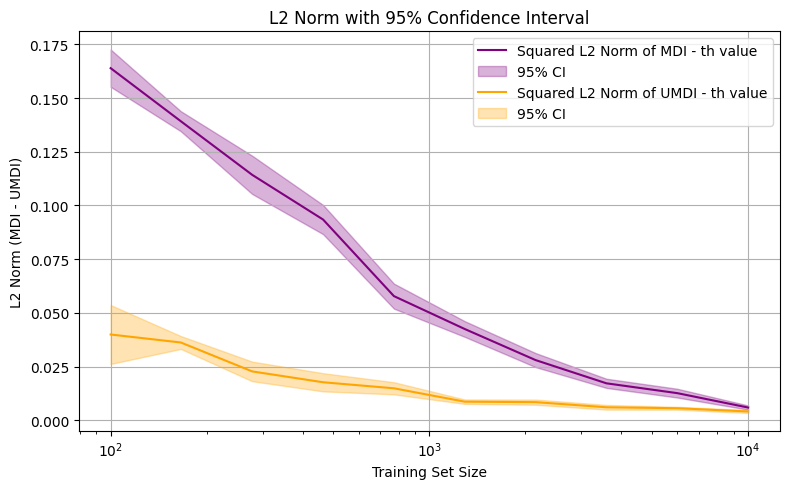

In [10]:
l2_mean_mdi = []
l2_sem_mdi = []
l2_mean_umdi = []
l2_sem_umdi = []

for t_idx in range(len(train_sizes_large)):
    mdi_vals = mdi_all[:, t_idx, :]
    umdi_vals = umdi_all[:, t_idx, :]

    l2_squared_mdi = np.sqrt(np.sum((mdi_vals - theoretical_value.repeat(5).reshape(7,5)) ** 2, axis=0))
    l2_squared_umdi = np.sqrt(np.sum((umdi_vals - theoretical_value.repeat(5).reshape(7,5)) ** 2, axis=0))
    l2_mean_mdi.append(l2_squared_mdi.mean())
    l2_sem_mdi.append(l2_squared_mdi.std(ddof=1) / np.sqrt(n_rep))
    l2_mean_umdi.append(l2_squared_umdi.mean())
    l2_sem_umdi.append(l2_squared_umdi.std(ddof=1) / np.sqrt(n_rep))

l2_mean_mdi = np.array(l2_mean_mdi)
l2_mean_umdi = np.array(l2_mean_umdi)
l2_sem_mdi = np.array(l2_sem_mdi)
l2_sem_umdi = np.array(l2_sem_umdi)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes_large, l2_mean_mdi, label='Squared L2 Norm of MDI - th value', color='purple')
plt.fill_between(
    train_sizes_large,
    l2_mean_mdi - 1.96 * l2_sem_mdi,
    l2_mean_mdi + 1.96 * l2_sem_mdi,
    color='purple',
    alpha=0.3,
    label='95% CI'
)

plt.plot(train_sizes_large, l2_mean_umdi, label='Squared L2 Norm of UMDI - th value', color='orange')
plt.fill_between(
    train_sizes_large,
    l2_mean_umdi - 1.96 * l2_sem_umdi,
    l2_mean_umdi + 1.96 * l2_sem_umdi,
    color='orange',
    alpha=0.3,
    label='95% CI'
)
plt.xscale('log')
plt.xlabel('Training Set Size')
plt.ylabel('L2 Norm (MDI - UMDI)')
plt.title('L2 Norm with 95% Confidence Interval')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Plot evolution as a heatmap and compare with SAGE

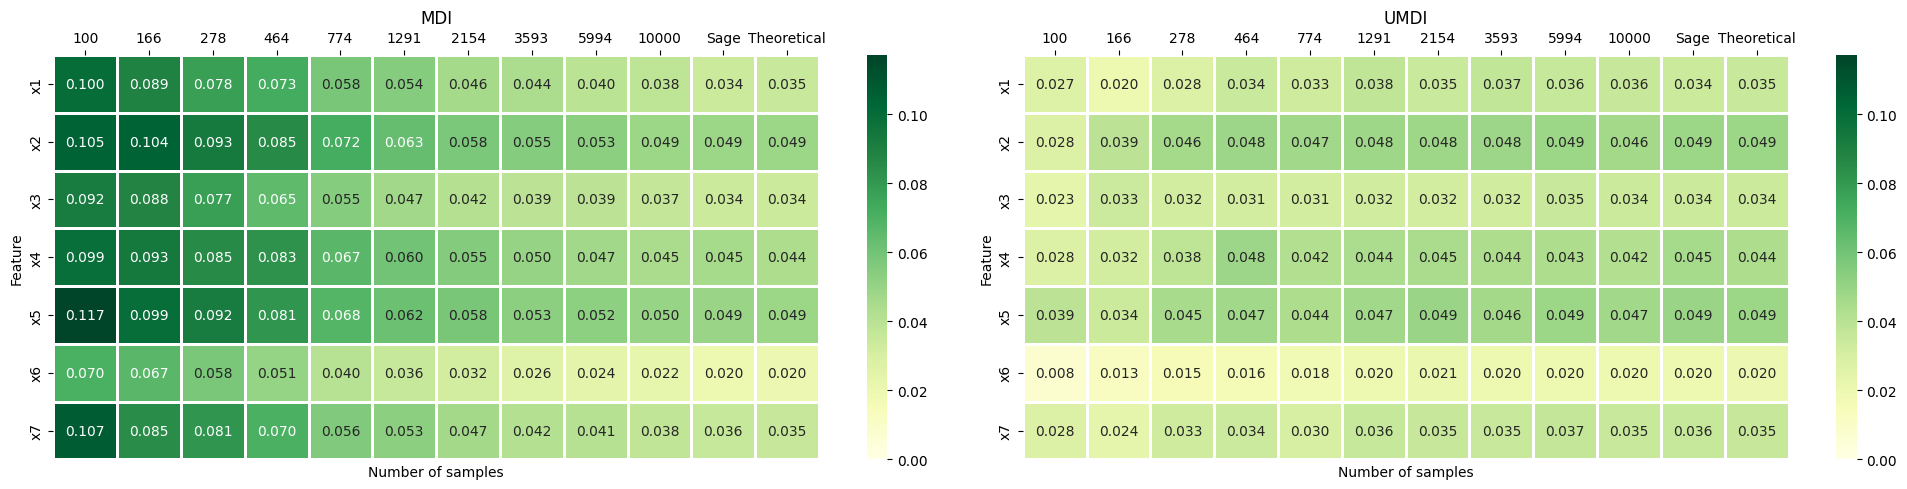

In [11]:
MDI_asymptotic = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
UMDI_asymptotic = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
for t_idx in range(len(train_sizes_large)):
    MDI_asymptotic.loc[:,f"{train_sizes_large[t_idx]}"] = np.mean(mdi_all[:, t_idx, :], axis=1)
    UMDI_asymptotic.loc[:,f"{train_sizes_large[t_idx]}"] = np.mean(umdi_all[:, t_idx, :], axis=1)

UMDI_asymptotic.loc[:, "Sage"] = np.mean(sage_values, axis=0)
MDI_asymptotic.loc[:, "Sage"] = np.mean(sage_values, axis=0)
UMDI_asymptotic.loc[:, "Theoretical"] = theoretical_value
MDI_asymptotic.loc[:, "Theoretical"] = theoretical_value

max_value = np.max([UMDI_asymptotic.max(), MDI_asymptotic.max()])

# Plot the heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.heatmap(
    MDI_asymptotic,
    annot=True,
    cmap="YlGn",
    fmt=".3f",
    linewidths=1,
    ax=axes[0],
    vmin=0,
    vmax=max_value,
)
axes[0].xaxis.tick_top()
axes[0].set_xlabel("Number of samples")
axes[0].set_ylabel("Feature")
axes[0].set_title("MDI")

sns.heatmap(
    UMDI_asymptotic,
    annot=True,
    cmap="YlGn",
    fmt=".3f",
    linewidths=1,
    ax=axes[1],
    vmin=0,
    vmax=max_value,
)
axes[1].xaxis.tick_top()
axes[1].set_xlabel("Number of samples")
axes[1].set_ylabel("Feature")
axes[1].set_title("UMDI")

plt.tight_layout()
plt.show()

In [12]:
feature_names = ["x1", "x2", "x3", "x4", "x5", "x6", "x7"]
train_sizes_largest = np.logspace(3, np.log10(n_samples_train_sage), 7, dtype=int)
mdi_large_res = np.zeros((len(feature_names), len(train_sizes_largest), n_rep))
umdi_large_res = np.zeros((len(feature_names), len(train_sizes_largest), n_rep))
brier_score_improvement = np.zeros((len(train_sizes_largest), n_rep))

for t_idx, n_samples in enumerate(train_sizes_largest):
    for rep in range(n_rep):
        X_train, y_train = make_noised_led_sample(
            n_samples=n_samples, flip_proba=flip_proba, random_state=rep
        )
        rf = ExtraTreesClassifier(
            n_estimators=n_estimators,
            max_features=1,
            max_depth=None,
            oob_score=True,
            bootstrap=True,
            n_jobs=-1,
            random_state=rep,
        )
        rf.fit(X_train, y_train)       
        mdi_large_res[:, t_idx, rep] = rf._unnormalized_feature_importances
        umdi_large_res[:, t_idx, rep] = rf.unbiased_feature_importances_

        X_test, y_test = make_noised_led_sample(
        n_samples=train_sizes_largest[t_idx], flip_proba=flip_proba, random_state=rep+100
        )
        dummy = DummyClassifier(random_state=42).fit(X_train, y_train)
        brier_score_improvement[t_idx, rep] = brier_score_loss(y_test, dummy.predict_proba(X_test)) - brier_score_loss(y_test, rf.predict_proba(X_test))


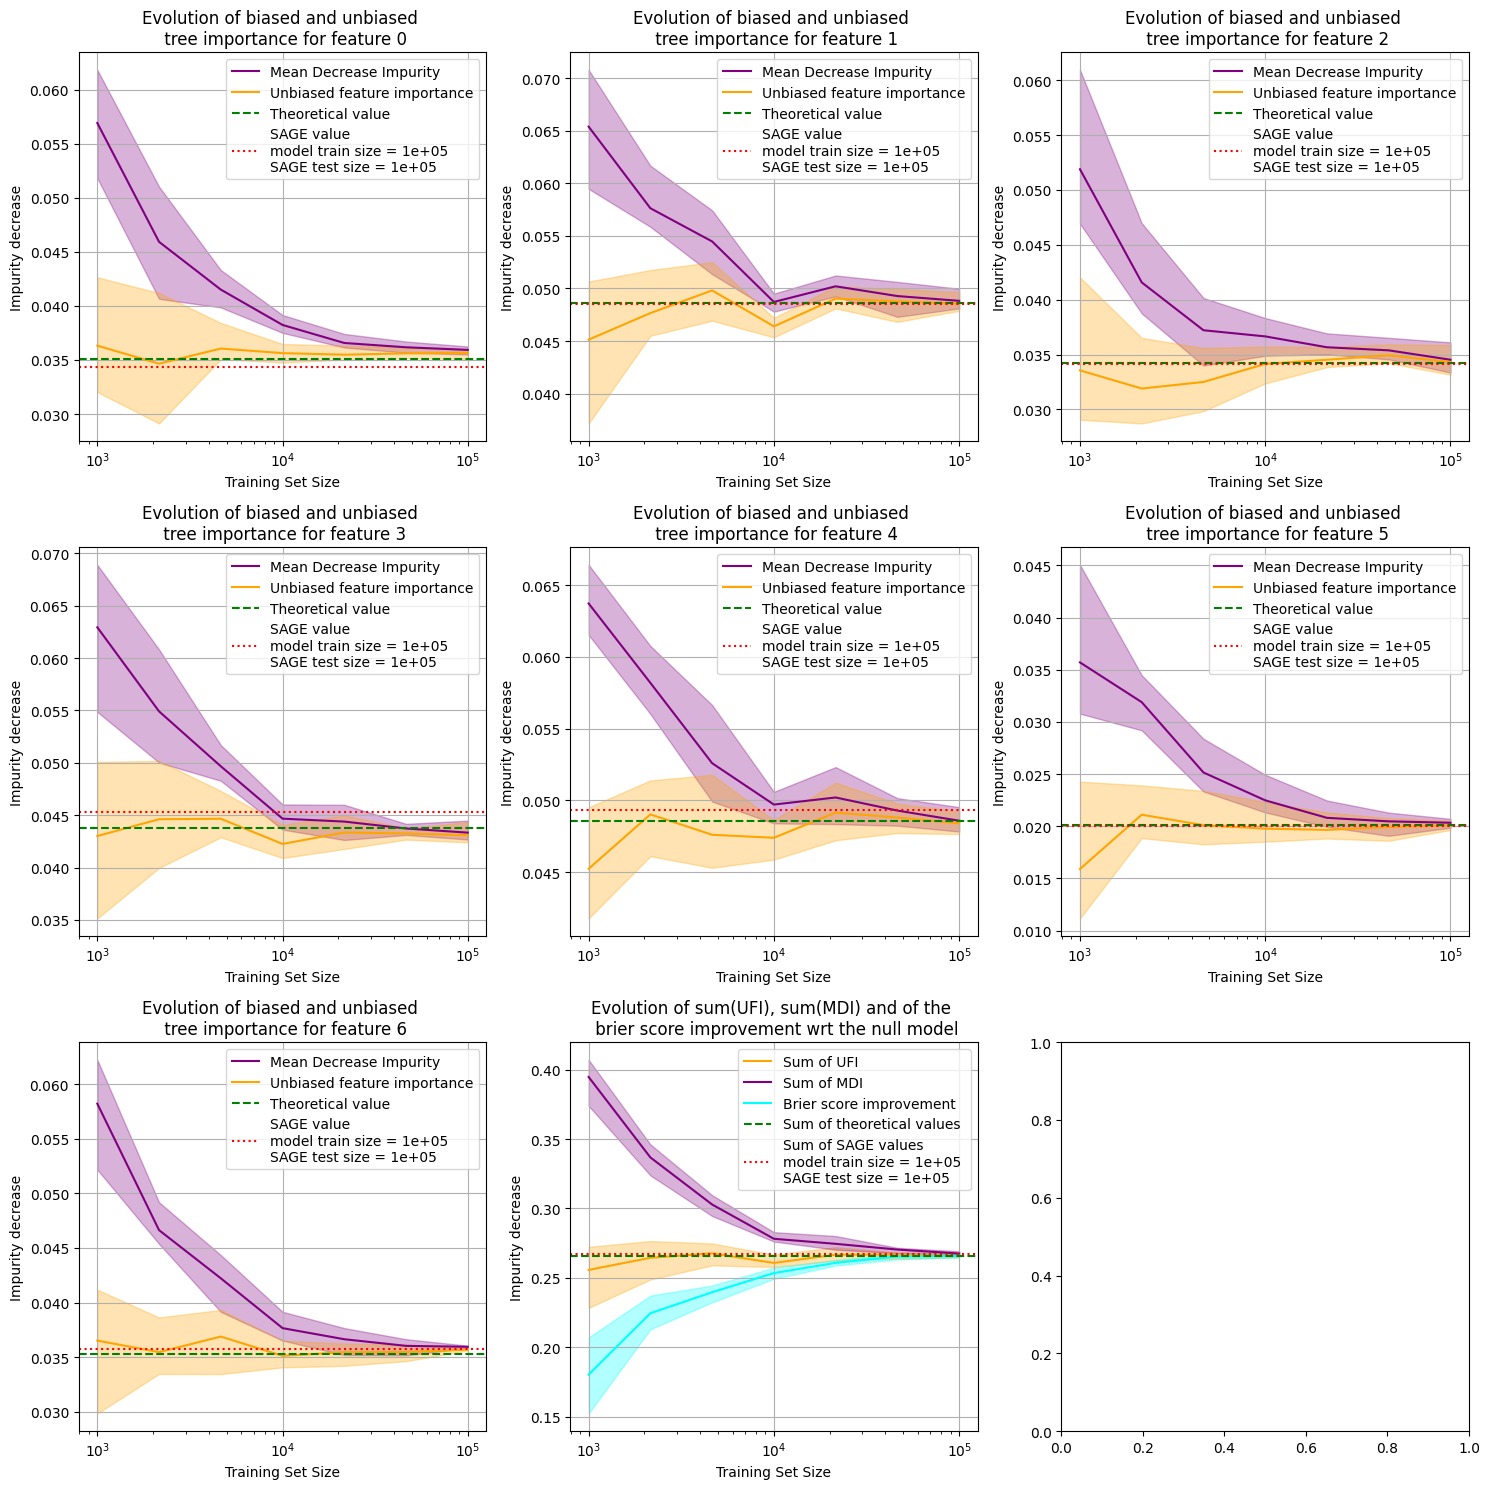

In [13]:
mean_mdi = np.zeros((len(train_sizes_largest), len(feature_names)))
quantiles_mdi = np.zeros((len(train_sizes_largest), len(feature_names), 2))
mean_umdi = np.zeros((len(train_sizes_largest), len(feature_names)))
quantiles_umdi = np.zeros((len(train_sizes_largest), len(feature_names), 2))
mean_brier = np.zeros(len(train_sizes_largest))
quantiles_brier = np.zeros((len(train_sizes_largest), 2))

for t_idx in range(len(train_sizes_largest)):
    mean_mdi[t_idx, :] = mdi_large_res[:, t_idx, :].mean(axis=1)
    quantiles_mdi[t_idx, :, :] = np.quantile(mdi_large_res[:, t_idx, :], q=(0.025, 0.975), axis=1).T
    mean_umdi[t_idx, :] = umdi_large_res[:, t_idx, :].mean(axis=1)
    quantiles_umdi[t_idx, :, :] = np.quantile(umdi_large_res[:, t_idx, :], q=(0.025, 0.975), axis=1).T

    mean_brier = brier_score_improvement[t_idx, :].mean()
    quantiles_brier[t_idx, :] = np.quantile(brier_score_improvement[t_idx, :], q=(0.025, 0.975)).T



# Plot
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

for i in range(7):
    axs[i].plot(train_sizes_largest, mean_mdi[:, i], label="Mean Decrease Impurity", color='purple')
    axs[i].fill_between(
        train_sizes_largest,
        quantiles_mdi[:, i, 0],
        quantiles_mdi[:, i, 1],
        color='purple',
        alpha=0.3,
    )
    axs[i].plot(train_sizes_largest, mean_umdi[:, i], label="Unbiased feature importance", color='orange')
    axs[i].fill_between(
        train_sizes_largest,
        quantiles_umdi[:, i, 0],
        quantiles_umdi[:, i, 1],
        color='orange',
        alpha=0.3,
    )
    axs[i].axhline(theoretical_value[i], ls="--", label="Theoretical value", color="green")
    axs[i].axhline(np.mean(sage_values, axis=0)[i], ls=":", label=f"SAGE value \nmodel train size = {n_samples_train_sage:.0g} \nSAGE test size = {n_samples_test_sage:.0g}", color="red")

    axs[i].set_xscale('log')
    axs[i].set_xlabel('Training Set Size')
    axs[i].set_ylabel('Impurity decrease')
    axs[i].set_title(f'Evolution of biased and unbiased \n tree importance for feature {i}')
    axs[i].grid(True)
    axs[i].legend()

axs[7].plot(train_sizes_largest, umdi_large_res.sum(axis=0).mean(axis=1), label="Sum of UFI", color='orange')
axs[7].fill_between(
    train_sizes_largest,
    np.quantile(umdi_large_res.sum(axis=0), q=(0.025, 0.975), axis=1).T[:, 0],
    np.quantile(umdi_large_res.sum(axis=0), q=(0.025, 0.975), axis=1).T[:, 1],
    color='orange',
    alpha=0.3,
)
axs[7].plot(train_sizes_largest, mdi_large_res.sum(axis=0).mean(axis=1), label="Sum of MDI", color='purple')
axs[7].fill_between(
    train_sizes_largest,
    np.quantile(mdi_large_res.sum(axis=0), q=(0.025, 0.975), axis=1).T[:, 0],
    np.quantile(mdi_large_res.sum(axis=0), q=(0.025, 0.975), axis=1).T[:, 1],
    color='purple',
    alpha=0.3,
)
axs[7].plot(train_sizes_largest, brier_score_improvement.mean(axis=1), label="Brier score improvement", color='cyan')
axs[7].fill_between(
        train_sizes_largest,
        quantiles_brier[:, 0],
        quantiles_brier[:, 1],
        color='cyan',
        alpha=0.3,
    )
axs[7].axhline(theoretical_value.sum(), ls="--", label="Sum of theoretical values", color="green")
axs[7].axhline(np.mean(sage_values, axis=0).sum(), ls=":", label=f"Sum of SAGE values \nmodel train size = {n_samples_train_sage:.0g} \nSAGE test size = {n_samples_test_sage:.0g}", color="red")

axs[7].set_xscale('log')
axs[7].set_xlabel('Training Set Size')
axs[7].set_ylabel('Impurity decrease')
axs[7].set_title('Evolution of sum(UFI), sum(MDI) and of the \n brier score improvement wrt the null model')
axs[7].grid(True)
axs[7].legend()

plt.tight_layout()
plt.show()
